<a href="https://colab.research.google.com/github/kim1987/aiffel/blob/main/aiffel/exploration/exploration_nineteen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

exploration_19  
with https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchtext
from torchvision import transforms
import torchvision
import os
import natsort
from PIL import Image
import numpy as np
import numpy

In [2]:
from IPython import display
from tqdm.notebook import tqdm

In [3]:
!pip install torchinfo

In [4]:
from torchinfo import summary

In [5]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())

A100-SXM4-40GB


데이터

In [6]:
!cp /content/drive/MyDrive/colabdata/aiffel/ex_onenine/cityscapes.zip /content/

In [7]:
torchtext.utils.extract_archive('/content/cityscapes.zip')

['/content/cityscapes/train/1.jpg',
 '/content/cityscapes/train/100.jpg',
 '/content/cityscapes/train/1000.jpg',
 '/content/cityscapes/train/101.jpg',
 '/content/cityscapes/train/102.jpg',
 '/content/cityscapes/train/106.jpg',
 '/content/cityscapes/train/109.jpg',
 '/content/cityscapes/train/112.jpg',
 '/content/cityscapes/train/113.jpg',
 '/content/cityscapes/train/114.jpg',
 '/content/cityscapes/train/116.jpg',
 '/content/cityscapes/train/119.jpg',
 '/content/cityscapes/train/12.jpg',
 '/content/cityscapes/train/124.jpg',
 '/content/cityscapes/train/128.jpg',
 '/content/cityscapes/train/135.jpg',
 '/content/cityscapes/train/137.jpg',
 '/content/cityscapes/train/139.jpg',
 '/content/cityscapes/train/140.jpg',
 '/content/cityscapes/train/144.jpg',
 '/content/cityscapes/train/148.jpg',
 '/content/cityscapes/train/153.jpg',
 '/content/cityscapes/train/154.jpg',
 '/content/cityscapes/train/156.jpg',
 '/content/cityscapes/train/159.jpg',
 '/content/cityscapes/train/16.jpg',
 '/content/city

In [8]:
class MyDataset(torch.utils.data.Dataset):


  def __init__(self,data_path,transforms = None):
    self.path = data_path
    self.data = []
    self.transforms = transforms
    
    for (root,_,fnames) in os.walk(self.path, followlinks=True): #sorted 필요한가?
      for fname in natsort.natsorted(fnames):
        self.data.append(os.path.join(root,fname))

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    my_image = torch.stack(transforms.ToTensor()(Image.open(self.data[idx])).chunk(2,dim=-1),dim=0)
    if self.transforms is not None:
      my_image = self.transforms(my_image)
      return my_image[0],my_image[1]
    return my_image[0],my_image[1]

 augmentation 좌우 회전, 좌우 반전.

In [137]:
mytrans = transforms.RandomApply(nn.ModuleList([transforms.RandomHorizontalFlip(),transforms.RandomRotation((-90,90))]),p=0.5)

In [138]:
train_data = MyDataset('/content/cityscapes/train',mytrans)
val_data = MyDataset('/content/cityscapes/val')

In [11]:
batch_size = 32

In [139]:
train_loader = torch.utils.data.DataLoader(dataset = train_data,batch_size = batch_size,shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_data,batch_size = batch_size,shuffle = True)

모델

In [13]:
class Downsample(nn.Module):
  
  def __init__(self,in_channels,out_channels,size,padding,apply_dropout=True):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=in_channels,out_channels = out_channels,kernel_size = size,stride = 2,padding = padding)
    self.norm = nn.BatchNorm2d(num_features=out_channels)
    self.dropout = nn.Dropout2d(p=0.5)
    self.relu = nn.ReLU()
    self.apply_dropout = apply_dropout
  def forward(self,inputs):
    x = self.conv(inputs)
    x = self.norm(x)
    if self.apply_dropout:
      x = self.dropout(x)
    return self.relu(x)


In [14]:
class Upsample(nn.Module):

  def __init__(self,in_channels,out_channels,size,padding,apply_dropout = False):
    super().__init__()
    self.convt = nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size=size,stride =2,padding = padding)
    self.norm = nn.BatchNorm2d(num_features=out_channels)
    self.dropout = nn.Dropout2d(p=0.5)
    self.relu = nn.ReLU()
    self.apply_dropout = apply_dropout
  def forward(self,inputs):
    x = self.convt(inputs)
    x = self.norm(x)
    if self.apply_dropout:
      x = self.dropout(x)
    return self.relu(x)


In [15]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    in_chs =  [3,64,128,256,512,512,512,512]
    out_chs = [64,128,256,512,512,512,512,512]
    out_up_chs = [64,128,256,512,512,512,512,256]
    sizes =[4,4,4,4,4,4,2,2]
    pad = [1,1,1,1,1,1,0,0]
    apply_dr_en = [False,True,True,True,True,True,True,True]
    apply_dr_de = [True,True,True,False,False,False,False,False]
    params = list(zip(in_chs,out_chs,sizes,pad))
    params_up = reversed(list(zip(out_up_chs,in_chs,sizes,pad)))
    self.encoders = nn.ModuleList([Downsample(in_ch,out_ch,size,padding,apply_dr) for (in_ch,out_ch ,size, padding),apply_dr in zip(params,apply_dr_en)])
    self.decoders = nn.ModuleList([Upsample(2*in_ch,out_ch,size,padding,apply_dr) for (in_ch, out_ch, size, padding),apply_dr in zip(params_up,apply_dr_de)])
    self.conv = nn.ConvTranspose2d(128,3,4,2,1)
  def forward(self,inputs,apply_dropout=True):
    x = inputs
    skip = []
    for layer in self.encoders:
      x = layer(x)
      skip.append(x)
    skip = reversed(skip[:-1])
    for skip_x,layer in zip(skip,self.decoders[:-1]):
      x = layer(x)
      x = torch.cat([x,skip_x],dim=1)
    x = self.conv(x)
    return x

In [16]:
test = Generator()

In [17]:
summary(test,(32,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-1                        --                        --
│    └─Downsample: 2-1                   [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [32, 64, 128, 128]        3,136
│    │    └─BatchNorm2d: 3-2             [32, 64, 128, 128]        128
│    │    └─ReLU: 3-3                    [32, 64, 128, 128]        --
│    └─Downsample: 2-2                   [32, 128, 64, 64]         --
│    │    └─Conv2d: 3-4                  [32, 128, 64, 64]         131,200
│    │    └─BatchNorm2d: 3-5             [32, 128, 64, 64]         256
│    │    └─Dropout2d: 3-6               [32, 128, 64, 64]         --
│    │    └─ReLU: 3-7                    [32, 128, 64, 64]         --
│    

In [18]:
class Discriminator(nn.Module):


  def __init__(self):
    super().__init__()

    self.down1 = Downsample(6,64,4,1)
    self.down2 = Downsample(64,128,4,1)
    self.down3 = Downsample(128,256,4,1)

    self.conv1 = nn.Conv2d(256,512,4,1,padding=1)
    self.batch = nn.BatchNorm2d(512)
    self.lrelu = nn.LeakyReLU()

    self.conv2 = nn.Conv2d(512,1,4,1,padding=1)

  def forward(self, inp,tar):
      x = torch.concat([inp,tar],dim=1)
      x = self.down3(self.down2(self.down1(x)))
      x = self.lrelu(self.batch(self.conv1(x)))
      return self.conv2(x)

In [19]:
test = Discriminator()

In [20]:
summary(test,[(32,3,256,256),(32,3,256,256)])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Downsample: 1-1                        [32, 64, 128, 128]        --
│    └─Conv2d: 2-1                       [32, 64, 128, 128]        6,208
│    └─BatchNorm2d: 2-2                  [32, 64, 128, 128]        128
│    └─Dropout2d: 2-3                    [32, 64, 128, 128]        --
│    └─ReLU: 2-4                         [32, 64, 128, 128]        --
├─Downsample: 1-2                        [32, 128, 64, 64]         --
│    └─Conv2d: 2-5                       [32, 128, 64, 64]         131,200
│    └─BatchNorm2d: 2-6                  [32, 128, 64, 64]         256
│    └─Dropout2d: 2-7                    [32, 128, 64, 64]         --
│    └─ReLU: 2-8                         [32, 128, 64, 64]         --
├─Downsample: 1-3                        [32, 256, 32, 32]         --
│    └─Conv2d: 2-9                       [32, 256, 32, 32]         524,544


train 준비

In [21]:
import gc
gc.collect()

213

In [108]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [123]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [131]:
LAMBDA = 100
generator_optimizer = torch.optim.Adam(generator.parameters(),lr=2e-4,betas=(0.5,0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.5,0.999))

In [125]:
loss_bce = torch.nn.BCEWithLogitsLoss()
loss_mse = torch.nn.MSELoss()

In [121]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_bce(disc_generated_output,torch.ones_like(disc_generated_output))
  
  l1_loss = loss_mse(gen_output,target)

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [126]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_bce(disc_real_output,torch.ones_like(disc_real_output))

  generated_loss = loss_bce(disc_generated_output,torch.zeros_like(disc_generated_output))

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [127]:
def generate_images(model, test_input, tar):

  model.eval()

  prediction = model(test_input.to(device)).to(torch.device('cpu')).permute(0,2,3,1).detach().numpy()
  
  plt.figure(figsize=(15,15))

  display_list = [test_input[0].permute(1,2,0).numpy(), tar[0].permute(1,2,0).numpy(), prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [128]:
def train_step(generator,discriminator,train_loader, epoch):
  for n,(target, input) in enumerate(tqdm(train_loader)):

    generator_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()
    
    input_image = input.to(device)
    target = target.to(device)

    gen_output = generator(input_image)
    disc_real_output = discriminator(input_image, target)
    disc_generated_output = discriminator(input_image, gen_output)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    gen_total_loss.backward(retain_graph=True)
    disc_loss.backward()

    generator_optimizer.step()
    discriminator_optimizer.step()
    if n == 0:
      print('epoch: ',epoch,'  gen_loss: ', gen_total_loss,'  dis_loss: ',disc_loss,'  gen_gan_loss: ',gen_gan_loss,'  gen_l1_loss: ',gen_l1_loss)
  return gen_output.to(torch.device('cpu'))

train

In [154]:
epochs = 10 #400 +10

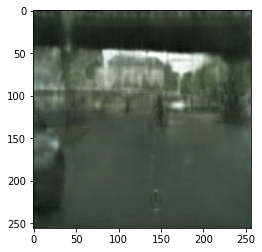

In [155]:
for epoch in range(epochs):
  generator.train()
  discriminator.train()
  myimage = train_step(generator,discriminator,train_loader,epoch)
  display.clear_output(wait=True)
  plt.imshow(myimage[0].permute(1,2,0).detach().numpy())
  plt.show()

In [160]:
test = next(iter(val_loader))

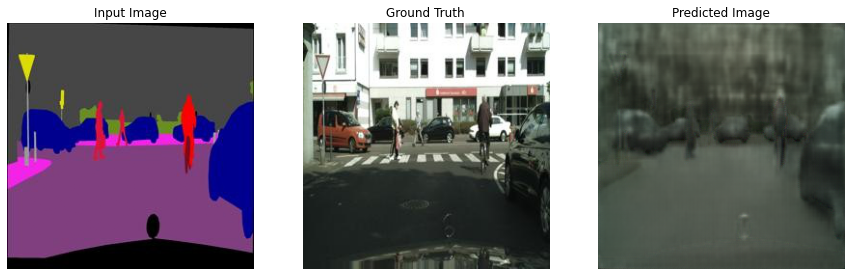

In [161]:
generate_images(generator,test[1][0].unsqueeze(0),test[0][0].unsqueeze(0))

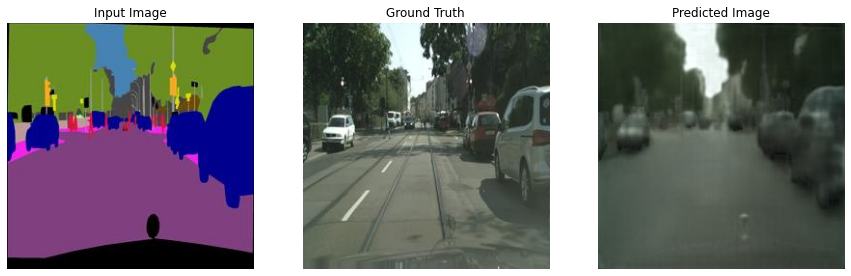

In [164]:
generate_images(generator,test[1][3].unsqueeze(0),test[0][3].unsqueeze(0))

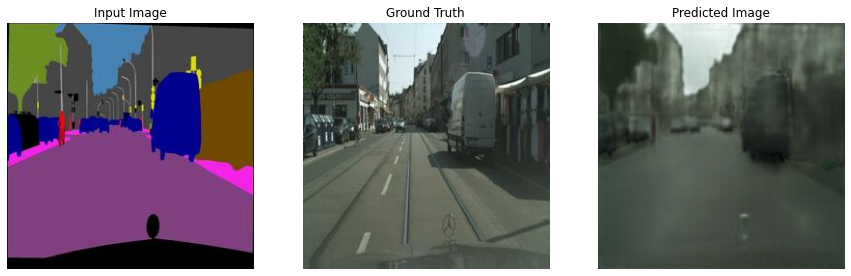

In [163]:
generate_images(generator,test[1][2].unsqueeze(0),test[0][2].unsqueeze(0))